# Overfitting & Regularization

State-of-the-art neural networks used in deep learning typically come with millions of weights. Unsurprisingly, it is therefore rarely an issue to push the training error to 0. In particular, without any regularization there is instant death through overfitting. In this notebook, we discuss possible avenues for combatting overfitting via regularization methods tailored for DL-applications.

## Data Augmentation

The cleanest and most effective way to avoid overfitting is to get more labelled data. For instance, when you do a search on *white mug* you obtain the following results. What could be the problem when training on this data set?

<img src="images/mug.png" alt="Drawing" style="width: 1000px;"/>


Unfortunately though, getting more labelled data also happens to be the most expensive option and can in many cases even be infeasible. What you can do is to artificially inflate the labelled data at your disposal. This is known as **data augmentation**.

More precisely, data augmentation consists of taking samples from the training set and applying small random geometric perturbations. This could be rotations, shifts, flipping, color changes, etc. 

The following example reveals how surprisingly simple it is to perform data augmentation in ``keras``. First, we load the MNIST data set and convert it to a good shape.

In [1]:
from keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = [np.expand_dims(dat, -1) for dat in [X_train, X_test]]

Using TensorFlow backend.


Then, we perform the actual data augmentation using the ``ImageDataGenerator``.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=45)

Now, we visualize the result of the augmentation.

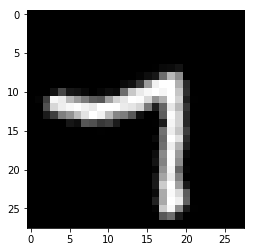

In [4]:
from matplotlib import pyplot
%matplotlib inline

pyplot.imshow(datagen.flow(X_train, y_train,
                          seed=42).next()[0][0,:,:,0], cmap=pyplot.get_cmap('gray'))

## $L_1$ & $L_2$ Regularization

As in classical statistics, we can also try to regularize the model by restricting suitable weight norms. For $L_2$-norm, this corresponds to [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), whereas $L_1$-norm yields [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics%29).

In [27]:
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Activation, Dense

model = Sequential()
model.add(Dense(64, input_shape=(10,), kernel_regularizer=regularizers.l2(1e-2)))
model.add(Activation('softmax'))

adam = optimizers.Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

In contrast to classical statistics, the effectiviness of weight regularization is limited in deep learning. On a second thought, this is not surprising, since the role of weights in deep nets is in stark contrast to the one in classical statistics. Deep nets are overparametrized on purpose -- we do not aim to reduce the weights to a small number of interpretable coefficients.

## Dropout

Dropout is a regularization technique specifically devised for deep learning. It was introduced in 2014 by [Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever & Ruslan Salakhutdinov](http://jmlr.org/papers/v15/srivastava14a.html). 

Deep nets tend to fit to the training data ridiculously well by creating highly elaborate interdepencies between different activation patterns. When seeing a new image, these highly elaborate interdependencies break down and the model is lost. 

__Dropout__ prevents the development of intricate dependencies by randomly resetting outputs of groups of neurons to 0 during training. During production all weights are used, but are rescaled by the dropout retention probability to account the difference to the training setting.

This is motivated from sexual reproduction in biology. This principle leads to a random mixing of genes, which ensures robustness in the face of changing environments. Make sure to watch https://www.youtube.com/watch?v=DleXA5ADG78 for details.

<img src="images/dropout.png" alt="Drawing" style="width: 700px;"/>
Srivastava, Nitish, et al. [Dropout: a simple way to prevent neural networks from
overfitting](http://jmlr.org/papers/v15/srivastava14a.html), JMLR 2014

This scaling rule can be established rigorously for basic architectures, see [Chapter 7.12 of the deep learning book](http://www.deeplearningbook.org/contents/regularization.html). It is a cousin of the *bagging* idea which lies at the basis of random forests.

The Keras documentation presents an example on how to use Dropout layers https://keras.io/getting-started/sequential-model-guide/. 

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, input_dim=20, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

## Batch Normalization

**Batch normalization**, is the most modern and powerful regularization method for deep nets. It was developed by [Sergey Ioffe & Christian Szegedy](https://arxiv.org/abs/1502.03167) in 2015 and is based on a simple, yet universally applicable paradigm: Standardize your inputs!

In backpropagation all layers are trained simultaneously. In particular, the input for higher layers is unstable for a long time, since it comes from lower hidden layers that are themselves subject to the training process. That is, we experience an **internal covariate shift**.

The most immediate approach is to standardize the inputs before activations are computed. However, this has to be done in  a way that is compatible with backpropagation, as the following [example](https://arxiv.org/abs/1502.03167) shows:

Suppose that a neuron receives an input from a lower layer, where a bias $b$ was added to the corresponding output $u$, i.e., $x = u + b$. Moreover, suppose we have training data $\{u_1, \ldots, u_N\}$ resulting in $\{x_1, \ldots, x_N\}$ after adding the bias. Naïve normalization would replace the input $u + b$ of a neuron by 
$$ u + b - \frac1N \sum_{i \le N} (u_i + b) = u - \frac1N \sum_{i \le N}{u_i}$$
Then, after a gradient step, the bias would be updated as $b + \Delta b$.

This causes a peculiar behavior: Since we subtract again the mean value with the new bias, the change of $b$ by $\Delta b$ did not have any effect on the output of the layer and the bias $b$ would escape to infinity.

The solution of the backpropagation algorithm is to normalize the data within every mini-batch and provide additional scaling and bias parameter $\gamma$ and $\beta$ that are part of the backpropagation:

<img src="images/batchnorm.PNG" alt="Drawing" style="width: 500px;"/>
Sergey Ioffe & Christian Szegedy: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).

We stress that the normalization is done *separately over each input* to a neuron. That means, for a neuron with input $\{x^{(1)}, \ldots x^{(d)}\}$ batch normalization introduces parameters $\gamma^{(1)}, \ldots, \gamma^{(d)}$ and $\beta^{(1)}, \ldots, \beta^{(d)}$.

In order to perform backpropagation, it is important that the procedure of batch normalization is differentiable. We verify this here for the derivatives with respect to the new parameters $\gamma$ and $\beta$:

$$\frac{\partial \ell}{\partial \gamma} = \sum_{i \le m} \frac{\partial \ell}{\partial y_i} \widehat{x_i}\quad\text{ and }\quad\frac{\partial \ell}{\partial \beta} = \sum_{i \le m} \frac{\partial \ell}{\partial y_i}.$$


During production the sample-mean and sample-variance over the mini-batches are replaced by the mean and variance over the entire 

Batch normalization offers two crucial benefits for training deep nets:

1. The normalization stabilizes the training process, thereby allowing for higher learning rates. Hence, the training is sped up.
2. Since means and variances are computed on each batch, the need for other regularization methods is reduced.

Here is an example of how to add batch normalization in Keras. Note that there is [no clear consensus](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) whether the batch normalization should be applied before or after the activation function.

In [13]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense

model = Sequential([
    Dense(64, input_dim=20, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])

## Homework

1. In batch normalization, compute the partial derivatives $\partial \ell/\partial \hat{x}_i$, $\partial \ell/\partial x_i$, $\partial \ell/\partial \mu_B$ and $\partial \ell/\partial \sigma_B^2$.
2. Implement dropout manually for a single-layer MLP.